In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.cm as cm
import pytensor.tensor as pt
import pdfplumber
import xarray as xr
sns.set_style("whitegrid")
import os,glob,sys
from pytensor.scan import scan


In [2]:
damip_direc="/Users/katemarvel/Documents/Attribution/DATA/GlobalMeans/tas"

In [3]:

def fopen(direc,fname):
    picfile=xr.open_dataset(direc+"/"+fname)
    annualmean=picfile.tas.groupby("time.year").mean(dim="time")
    
    return annualmean

In [4]:
# train with piControl
def get_piControl(model):
    piCdirec="/".join([damip_direc,model,"piControl"])
    picfiles=glob.glob(os.path.join(piCdirec,"*.nc"))




    # Temporary list 
    data_list = []

    for fname in picfiles:
        myfile=xr.open_dataset(fname)
        vec=myfile.tas.groupby("time.year").mean(dim="time")
        
        data_list.append(vec-vec.mean())
    piC_data = np.concatenate(data_list)
    return piC_data
    # piC_concatenate_mean=np.average(piC_concatenate)
    # piC_data=piC_concatenate-piC_concatenate_mean

def get_experiment(model,experiment,rolling=1):
    exdirec="/".join([damip_direc,model,experiment])
    #efiles=os.listdir(exdirec)
    efiles=glob.glob(os.path.join(exdirec,"*.nc"))
    # Temporary list 
    edata_list = []

    for fname in efiles:
        ###REMOVE
        myfile=xr.open_dataset(fname)
        annualmean=myfile.tas.groupby("time.year").mean(dim="time")
        if experiment != "piControl":
            vec = annualmean.sel(year=slice(1850,2014))
        else:
            vec=annualmean
        edata_list.append(vec-vec[:50].mean())
    experiment_data = np.vstack(edata_list)
    return experiment_data


# Read in DAMIP simulation data (global mean T)

In [8]:
GCM_F={}
forcings=["hist-GHG","hist-CO2","hist-aer","hist-nat"]
for forcing in forcings:
    
    GCM_F[forcing]={}
    for model in sorted(os.listdir(damip_direc))[1:]:
        try:
            data=get_experiment(model,forcing)
        #print(model)
            GCM_F[forcing][model]=data
        except:
            continue



forcings=["historical"]
for forcing in forcings:
    
    GCM_F[forcing]={}
    for model in sorted(os.listdir(damip_direc))[1:]:
        
        try:
            data=get_experiment(model,forcing)
            GCM_F[forcing][model]=data
        except:
            continue

GCM_F["piControl"]={}
for model in sorted(os.listdir(damip_direc))[1:]:
    try:
        data=get_piControl(model)
        GCM_F["piControl"][model] = data
    except:
        continue

/Users/katemarvel/mambaforge/envs/current/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/katemarvel/mambaforge/envs/current/lib/python3.11/site-packages/xarray/core/indexing.py:556: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()
/Users/katemarvel/mambaforge/envs/current/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/katemarvel/mambaforge/en

# Read in HadCRUT

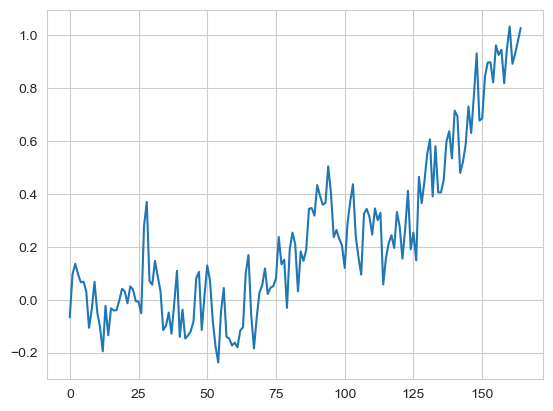

In [9]:
f_obs=xr.open_dataset("/Users/katemarvel/Documents/Attribution/DATA/Observations/HadCRUT.5.1.0.0.analysis.ensemble_series.global.annual.nc")
H_obs=f_obs.tas.mean(dim="realization").sel(time=slice("1850-1-1","2014-12-31"))
H_obs = H_obs-H_obs.sel(time=slice("1850-1-1","1899-12-31")).mean().values
plt.plot(H_obs)


# NOISE MODEL
We characterize the noise by an AR(3) process. The posterior for $\rho_1$ is weighted positive and $\rho_2$ is negative- this captures oscillations in the data, since the positive influence of one year will be counteracted by the negative influence of the previous year. The AR(1) and AR(3) coefficients reflect variability at different timescales.  (We could also use a sum of AR(1) processes as in Ribes et al 2021 but this is easier)

In [115]:

n_ar=3
# Concatenate the last 500 years of each piControl run to (hopefully) handle drift
C_conc=np.concatenate([GCM_F["piControl"][model][-500:] for model in GCM_F["piControl"].keys()])
with pm.Model() as ARonly:
    rho=pm.Uniform("rho",-1,1,shape=(n_ar))
    sigma_innov=pm.HalfNormal("sigma_innov",10)
    pm.AR("lik",rho=rho,sigma=sigma_innov,observed=C_conc)
    ARonly_trace=pm.sample()

/Users/katemarvel/mambaforge/envs/current/lib/python3.11/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, sigma_innov]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.



Here are the posteriors for the $\rho$ terms

array([<Axes: title={'center': 'rho\n0'}>,
       <Axes: title={'center': 'rho\n1'}>,
       <Axes: title={'center': 'rho\n2'}>], dtype=object)

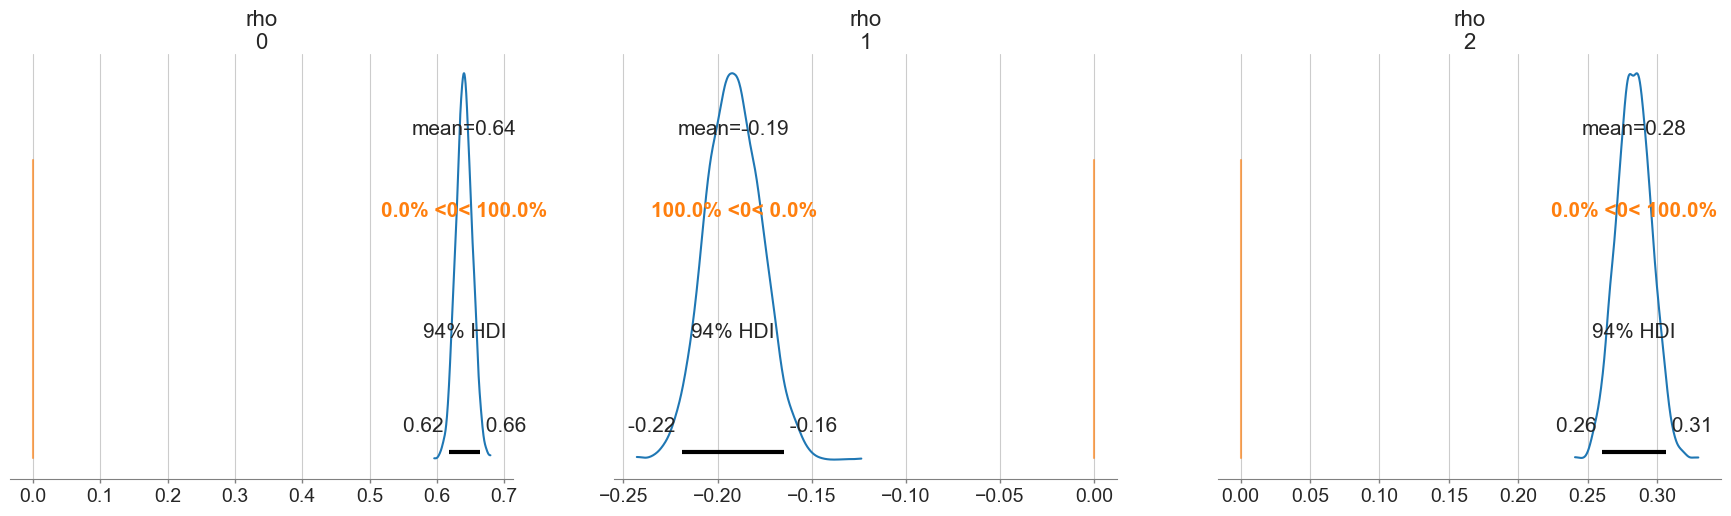

In [227]:
az.plot_posterior(ARonly_trace,var_names=["rho"],ref_val=0)

## Incorporating noise uncertainty into the D&A analysis
Now let's take the uncertainty in these parameters into account when doing our D&A multivariate regression.  We'll assume the posteriors are Gaussian (pretty reasonable) and take their means and stds.

In [125]:

rho_mean = ARonly_trace.posterior.rho.mean(dim=("chain","draw")).values
sigma_innov_mean = float(ARonly_trace.posterior.sigma_innov.mean(dim=("chain","draw")))
rho_std = ARonly_trace.posterior.rho.std(dim=("chain","draw")).values
sigma_innov_std = float(ARonly_trace.posterior.sigma_innov.std(dim=("chain","draw")))


Helper function to fit an AR(p) to residuals $H(t) - \sum \beta_i F_i(t)$ in the regression

In [47]:
def logp_arp(residual, rho, sigma):
    """
    Custom log-likelihood for AR(p) process with known rho and sigma.
    residual: symbolic tensor (T,)
    rho: vector of shape (p,)
    sigma: scalar
    """
    if isinstance(rho, pt.TensorVariable):
        p=rho.shape.eval()[0]
    else:
        p=len(rho)

    # First p values ~ stationary distribution approximation
    logp0 = pm.logp(
        pm.Normal.dist(mu=0, sigma=sigma / pt.sqrt(1 - pt.sum(rho**2))),
        residual[:p]
    )

    # Create matrix of lagged residuals: shape (T - p, p)
    # Instead of using Python range(), we use PyTensor indexing
    def lag_matrix(residual, p):
        """
        Construct a lag matrix of shape (T - p, p)
        Each row t contains: [residual[t-1], ..., residual[t-p]]
        """
        return pt.stack(
            [residual[i : -(p - i)] for i in range(p)],
            axis=1
        )


    eps_mat = lag_matrix(residual, p)     # shape (T - p, p)
    eps_pred = pt.sum(eps_mat * rho[::-1], axis=1)  # predicted epsilon_t
    eps_actual = residual[p:]             # actual epsilon_t

    logp_rest = pm.logp(pm.Normal.dist(mu=eps_pred, sigma=sigma), eps_actual)

    return logp0 + pt.sum(logp_rest)


# Full detection and attribution analysis

In [202]:
#def create_noise_submodel(C_conc,rho_prior,sigma_innov_prior):
def create_noise_submodel(C_conc,rho_prior,sigma_innov_prior):
    """
    Create sub-model for concatenated preindustrial noise
    
    Parameters:
    -----------
    C_conc : array-like, shape (n_years,)
        Concatenated piControl forcing
    rho_prior: TensorVariable, shape (p,)
        The prior for the AR(p) coefficients ρ_i. Number of lags will be inferred from rho shape
    sigma_innov_prior: TensorVariable, shape (1,)
        The prior for the innovation term σ
    Returns:
    --------
    dict with model parameters
    """
    
    likelihood = pm.AR("likelihood_piC",
                       rho=rho_prior,
                       sigma=sigma_innov_prior,
                       observed=C_conc)
    return {"likelihood_piC": likelihood}

In [48]:
def create_forcing_submodel(ensemble_data, model_name, forcing_name, F_true, sigma_shared):
    """
    Create sub-model for one GCM's ensemble members for a specific forcing.
    
    Parameters:
    -----------
    ensemble_data : array-like, shape (n_ensemble, n_years)
        Ensemble members for this model and forcing
    model_name : str
        Name of the GCM model
    forcing_name : str
        Name of the forcing (e.g., 'aer', 'CO2', 'nat', 'GHG')
    F_true : TensorVariable, shape (n_years,)
        The model's true forced response (shared parameter)
    sigma_shared : TensorVariable
        Shared within-model variability parameter
    
    Returns:
    --------
    dict with model parameters
    """
    # Likelihood: each ensemble member ~ N(F_model^true, sigma_model)
    # Use model-specific and forcing-specific ensemble dimension name
    likelihood = pm.Normal(
        f"obs_{forcing_name}_{model_name}",
        mu=F_true,
        sigma=sigma_shared,
        observed=ensemble_data,
        dims=(f"ensemble_{forcing_name}_{model_name}", "time")
    )
    
    return {"likelihood": likelihood}

In [203]:
def create_multi_forcing_model(GCM_F, forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'], 
                                n_years=165, H_obs=None, estimate_betas=True,use_historical=False,\
                              n_ar=3):
    """
    Create joint hierarchical model for multiple DAMIP forcings with detection & attribution.
    
    Parameters:
    -----------
    GCM_F : dict
        GCM_F[forcing][model] = array of shape (n_ensemble, n_years)
        GCM_F["piControl"][model] = array of shape (n_control, n_years) for internal variability
    forcings : list of str
        List of forcing types to model jointly
    n_years : int
        Number of years (default 165)
    H_obs : array-like, shape (n_years,), optional
        Observed time series to attribute
    estimate_betas : bool
        Whether to estimate scaling factors for detection & attribution
    
    Returns:
    --------
    pm.Model object, dict of submodels
    """
    # Get all unique model names across forcings
    all_models = set()
    for forcing in forcings:
        if forcing in GCM_F:
            all_models.update(GCM_F[forcing].keys())
    model_names = sorted(list(all_models))
    n_models = len(model_names)
    
    # Map forcing names to clean variable names
    forcing_map = {
        'hist-aer': 'aer',
        'hist-CO2': 'CO2',
        'hist-nat': 'nat',
        'hist-GHG': 'GHG',
        'historical': 'all'
    }
    
    # Setup coordinates
    coords = {
        "time": np.arange(n_years),
        "model": model_names,
    }
    
    # Add ensemble coordinates AND model-specific coordinates for each forcing
    for forcing in forcings + ["historical"]:
        if forcing not in GCM_F:
            continue
        forcing_clean = forcing_map[forcing]
        
        # Add model coordinate for this forcing (list of models with this forcing)
        forcing_models = list(GCM_F[forcing].keys())
        coords[f"model_{forcing_clean}"] = forcing_models
        
        # Add ensemble coordinates for each model
        for model_name in forcing_models:
            n_ensemble = GCM_F[forcing][model_name].shape[0]
            coords[f"ensemble_{forcing_clean}_{model_name}"] = np.arange(n_ensemble)
    
#     # Add piControl coordinates if available
#     if "piControl" in GCM_F:
#         for model_name in GCM_F["piControl"].keys():
#             n_control = GCM_F["piControl"][model_name].shape[0]
#             coords[f"ensemble_piControl_{model_name}"] = np.arange(n_control)
    
    with pm.Model(coords=coords) as model:
        # ===== Shared within-model variability =====
        # Same sigma for all forcings (internal variability)
        sigma_internal={}
        for model_name in model_names:
            sigma_internal[model_name] = pm.HalfNormal(f"sigma_internal_{model_name}", sigma=1.0)
        
        # ===== Store submodels and forcing-specific parameters =====
        submodels = {}
        F_dict = {}  # Store the latent true forced responses
        
        # ===== Process each forcing =====
        for forcing in forcings:
            if forcing not in GCM_F:
                print(f"Warning: {forcing} not found in GCM_F, skipping...")
                continue
                
            forcing_clean = forcing_map[forcing]
            forcing_data = GCM_F[forcing]
            forcing_models = list(forcing_data.keys())
            n_forcing_models = len(forcing_models)
            
            # Between-model variability (structural uncertainty) - specific to each forcing
            tau = pm.HalfNormal(f"tau_{forcing_clean}", sigma=0.5)
            
            # Latent "true" forced response for this forcing
            F_mean = pm.Normal(f"F_{forcing_clean}", mu=0, sigma=2, dims="time")
            
            # Model-specific latent forced responses
            # F_model^true ~ N(F, tau) for each model
            # Only create for models that have data for this forcing
            F_models = pm.Normal(
                f"F_{forcing_clean}_model_true",
                mu=F_mean,
                sigma=tau,
                shape=(n_forcing_models, n_years),
                dims=(f"model_{forcing_clean}", "time")
            )
            
            # Store the latent forcing for derived quantities
            F_dict[forcing_clean] = F_mean
            
            # Create sub-models for each GCM
            submodels[forcing_clean] = {}
            for i, model_name in enumerate(forcing_models):
                ensemble_data = forcing_data[model_name]
                
                submodels[forcing_clean][model_name] = create_forcing_submodel(
                    ensemble_data=ensemble_data,
                    model_name=model_name,
                    forcing_name=forcing_clean,
                    F_true=F_models[i, :],
                    sigma_shared=sigma_internal[model_name]
                )
            
            # Multi-model mean and spread for this forcing
            mm_mean = pm.Deterministic(
                f"mm_mean_{forcing_clean}", 
                F_models.mean(axis=0), 
                dims="time"
            )
            mm_std = pm.Deterministic(
                f"mm_std_{forcing_clean}", 
                F_models.std(axis=0), 
                dims="time"
            )
        
        # ===== Derived forcing: F_nonCO2 = F_GHG - F_CO2 =====
        if 'GHG' in F_dict and 'CO2' in F_dict:
            F_nonCO2 = pm.Deterministic(
                "F_nonCO2",
                F_dict['GHG'] - F_dict['CO2'],
                dims="time"
            )
            F_dict['nonCO2'] = F_nonCO2
        
        # ===== Optional: Total anthropogenic forcing =====
        if 'GHG' in F_dict and 'aer' in F_dict:
            F_anthro = pm.Deterministic(
                "F_anthro",
                F_dict['GHG'] + F_dict['aer'],  # GHG + aerosols
                dims="time"
            )
        
        # ===== Detection & Attribution Component =====
        if H_obs is not None and estimate_betas:
            
            # ===== Scaling factors (betas) =====
            # beta_GHG applies to both CO2 and nonCO2
#             beta_GHG = pm.Normal("beta_GHG", mu=1, sigma=0.5)
#             beta_aer = pm.Normal("beta_aer", mu=1, sigma=0.5)
#             beta_nat = pm.Normal("beta_nat", mu=1, sigma=0.5)
            
            beta_GHG = pm.HalfNormal("beta_GHG",sigma=0.5)
            beta_aer = pm.HalfNormal("beta_aer",  sigma=0.5)
            beta_nat = pm.HalfNormal("beta_nat", sigma=0.5)
            
     
            # ===== Construct expected observations =====
            # H = beta_aer*F_aer + beta_GHG*F_CO2 + beta_GHG*F_nonCO2 + beta_nat*F_nat
           
            H_forced = pm.math.zeros_like(time)
            
            
            if 'aer' in F_dict:
                H_forced = H_forced + beta_aer * F_dict['aer']
            if 'CO2' in F_dict:
                H_forced = H_forced + beta_GHG * F_dict['CO2']
            if 'nonCO2' in F_dict:
                H_forced = H_forced + beta_GHG * F_dict['nonCO2']
            if 'nat' in F_dict:
                H_forced = H_forced + beta_nat * F_dict['nat']
            
            H_forced = pm.Deterministic("H_forced", H_forced, dims="time")
            
            
            
            internal_variability=H_obs.values-H_forced
            
            
            # ===== Sample the AR(p) parameters learned from piControl =====
            
#             rho=pm.Normal("rho",mu=0,sigma=1,shape=(n_ar,))

#             sigma_innovation=pm.HalfNormal("sigma_innov",1)
                
   
#             submodels["piControl"]=create_noise_submodel(C_conc,rho,sigma)
            rho=pm.Normal("rho",mu=rho_mean,sigma=rho_std)

            sigma_innovation=pm.TruncatedNormal("sigma_innovation",
                                       mu=sigma_innov_mean,
                                                sigma=sigma_innov_std,
                                               lower=0)
            submodels["piControl"]=create_noise_submodel(C_conc,rho,sigma_innovation)
            pm.Potential("arp_likelihood", logp_arp(internal_variability, rho=rho, sigma=sigma_innovation))
            
            # ===== Process each forcing =====
            if use_historical:
                forcing = "historical"  
                forcing_clean = "all"
                forcing_data = GCM_F["historical"]
                forcing_models = list(forcing_data.keys())

                n_forcing_models = len(forcing_models)

                forcing_models = list(GCM_F[forcing].keys())


                # Between-model variability (structural uncertainty) - specific to each forcing
                tau = pm.HalfNormal(f"tau_{forcing_clean}", sigma=0.5)

                # Latent "true" forced response for this forcing
                F_mean = pm.Deterministic("F_historical",\
                                          F_dict["aer"]+F_dict["CO2"]+F_dict["nonCO2"]+F_dict["nat"])

                # Model-specific latent forced responses
                # F_model^true ~ N(F, tau) for each model
                # Only create for models that have data for this forcing
                F_models = pm.Normal(
                    f"F_{forcing_clean}_model_true",
                    mu=F_mean,
                    sigma=tau,
                    shape=(n_forcing_models, n_years),
                    dims=(f"model_{forcing_clean}", "time")
                )

                # Store the latent forcing for derived quantities
                F_dict[forcing_clean] = F_mean

                # Create sub-models for each GCM
                submodels[forcing_clean] = {}
                for i, model_name in enumerate(forcing_models):
                    ensemble_data = forcing_data[model_name]

                    submodels[forcing_clean][model_name] = create_forcing_submodel(
                        ensemble_data=ensemble_data,
                        model_name=model_name,
                        forcing_name=forcing_clean,
                        F_true=F_models[i, :],
                        sigma_shared=sigma_internal[model_name]
                    )




            
            # ===== Attributable responses =====
            # attributable_forcing = beta_forcing * F_forcing
            if 'aer' in F_dict:
                pm.Deterministic("attributable_aer", beta_aer * F_dict['aer'], dims="time")
            if 'CO2' in F_dict:
                pm.Deterministic("attributable_CO2", beta_GHG * F_dict['CO2'], dims="time")
            if 'nonCO2' in F_dict:
                pm.Deterministic("attributable_nonCO2", beta_GHG * F_dict['nonCO2'], dims="time")
            if 'nat' in F_dict:
                pm.Deterministic("attributable_nat", beta_nat * F_dict['nat'], dims="time")
           
            
            # Total attributable anthropogenic
            if 'GHG' in F_dict and 'aer' in F_dict:
                pm.Deterministic(
                    "attributable_anthro",
                    beta_GHG * F_dict['GHG'] + beta_aer * F_dict['aer'],
                    dims="time"
                )
    
    return model, submodels

In [204]:
def fit_multi_forcing_model(GCM_F, forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'],
                             n_years=165, H_obs=None, estimate_betas=True,
                             n_samples=2000, n_tune=1000, n_chains=4,\
                           use_historical=False,n_ar=3):
    """
    Fit the multi-forcing hierarchical model.
    
    Parameters:
    -----------
    GCM_F : dict
        GCM_F[forcing][model] = array of shape (n_ensemble, n_years)
    forcings : list of str
        List of forcing types to model jointly
    H_obs : array-like, shape (n_years,), optional
        Observed time series for detection & attribution
    estimate_betas : bool
        Whether to estimate scaling factors
    n_samples, n_tune, n_chains : int
        MCMC sampling parameters
        
    Returns:
    --------
    model, trace, submodels
    """
    # Create model
    model, submodels = create_multi_forcing_model(GCM_F, forcings, n_years, H_obs, estimate_betas,use_historical)
    
    # Sample
    with model:
        trace = pm.sample(
            draws=n_samples,
            tune=n_tune,
            chains=n_chains,
            target_accept=0.95,
            return_inferencedata=True
        )
    
    return model, trace, submodels

In [205]:
if __name__ == "__main__":
    np.random.seed(123)
    
  
    n_years = 165
    time = np.arange(n_years)
    
  
    # Fit model
    print("Fitting joint multi-forcing hierarchical model with detection & attribution...")
    model, trace, submodels = fit_multi_forcing_model(
        GCM_F,
        forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'],
        n_years=n_years,
        H_obs=H_obs,
        estimate_betas=True,
        use_historical=True,
        n_samples=1000,
        n_tune=500,
        n_chains=2
    )
   

Fitting joint multi-forcing hierarchical model with detection & attribution...


/Users/katemarvel/mambaforge/envs/current/lib/python3.11/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma_internal_ACCESS-CM2, sigma_internal_ACCESS-ESM1-5, sigma_internal_BCC-CSM2-MR, sigma_internal_CESM2, sigma_internal_CNRM-CM6-1, sigma_internal_CanESM5, sigma_internal_FGOALS-g3, sigma_internal_GFDL-CM4, sigma_internal_GFDL-ESM4, sigma_internal_GISS-E2-1-G, sigma_internal_HadGEM3-GC31-LL, sigma_internal_IPSL-CM6A-LR, sigma_internal_MIROC6, sigma_internal_MRI-ESM2-0, sigma_internal_NorESM2-LM, tau_aer, F_aer, F_aer_model_true, tau_CO2, F_CO2, F_CO2_model_true, tau_nat, F_nat, F_nat_model_true, tau_GHG, F_GHG, F_GHG_model_true, beta_GHG, beta_aer, beta_nat, rho, sigma_innovatio

Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 155 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'sigma_internal_ACCESS-CM2'}>,
        <Axes: title={'center': 'sigma_internal_ACCESS-ESM1-5'}>,
        <Axes: title={'center': 'sigma_internal_BCC-CSM2-MR'}>],
       [<Axes: title={'center': 'sigma_internal_CESM2'}>,
        <Axes: title={'center': 'sigma_internal_CNRM-CM6-1'}>,
        <Axes: title={'center': 'sigma_internal_CanESM5'}>],
       [<Axes: title={'center': 'sigma_internal_FGOALS-g3'}>,
        <Axes: title={'center': 'sigma_internal_GFDL-CM4'}>,
        <Axes: title={'center': 'sigma_internal_GFDL-ESM4'}>],
       [<Axes: title={'center': 'sigma_internal_GISS-E2-1-G'}>,
        <Axes: title={'center': 'sigma_internal_HadGEM3-GC31-LL'}>,
        <Axes: title={'center': 'sigma_internal_IPSL-CM6A-LR'}>],
       [<Axes: title={'center': 'sigma_internal_MIROC6'}>,
        <Axes: title={'center': 'sigma_internal_MRI-ESM2-0'}>,
        <Axes: title={'center': 'sigma_internal_NorESM2-LM'}>]],
      dtype=object)

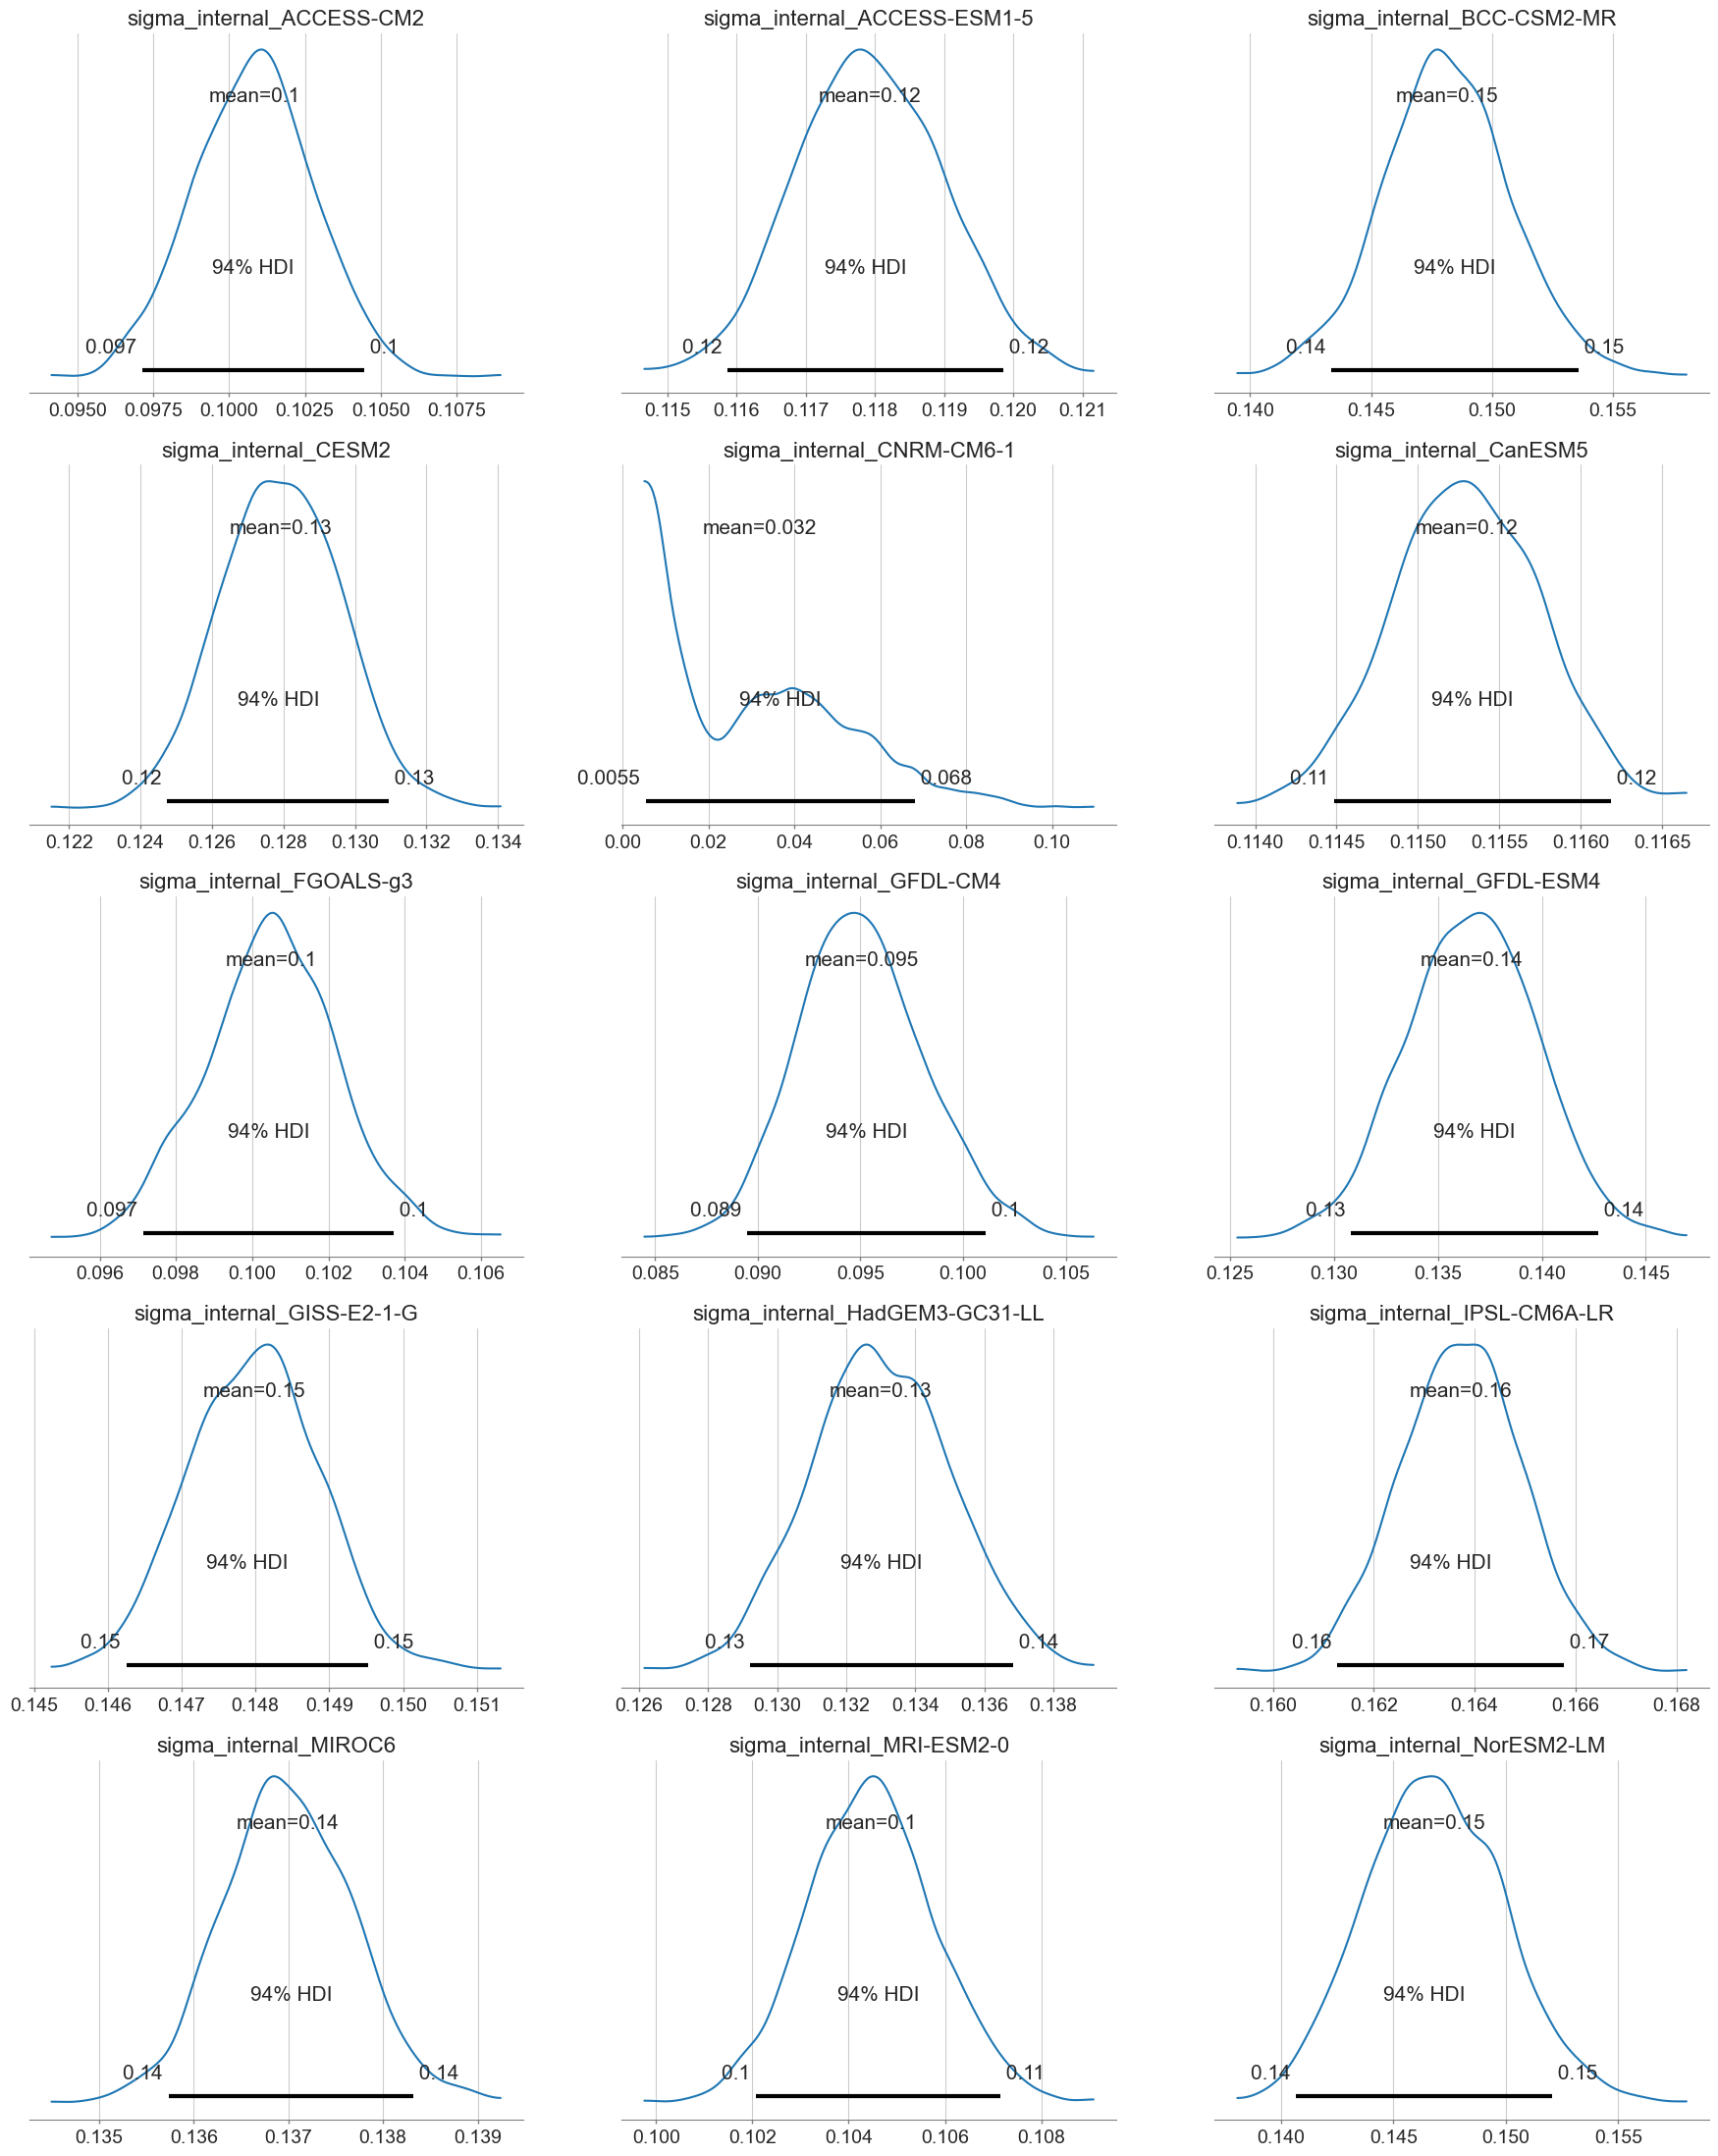

In [206]:

az.plot_posterior(trace,var_names=[f"sigma_internal_{model_name}" for model_name in model.coords["model"]])

array([<Axes: title={'center': 'beta_GHG'}>,
       <Axes: title={'center': 'beta_nat'}>,
       <Axes: title={'center': 'beta_aer'}>], dtype=object)

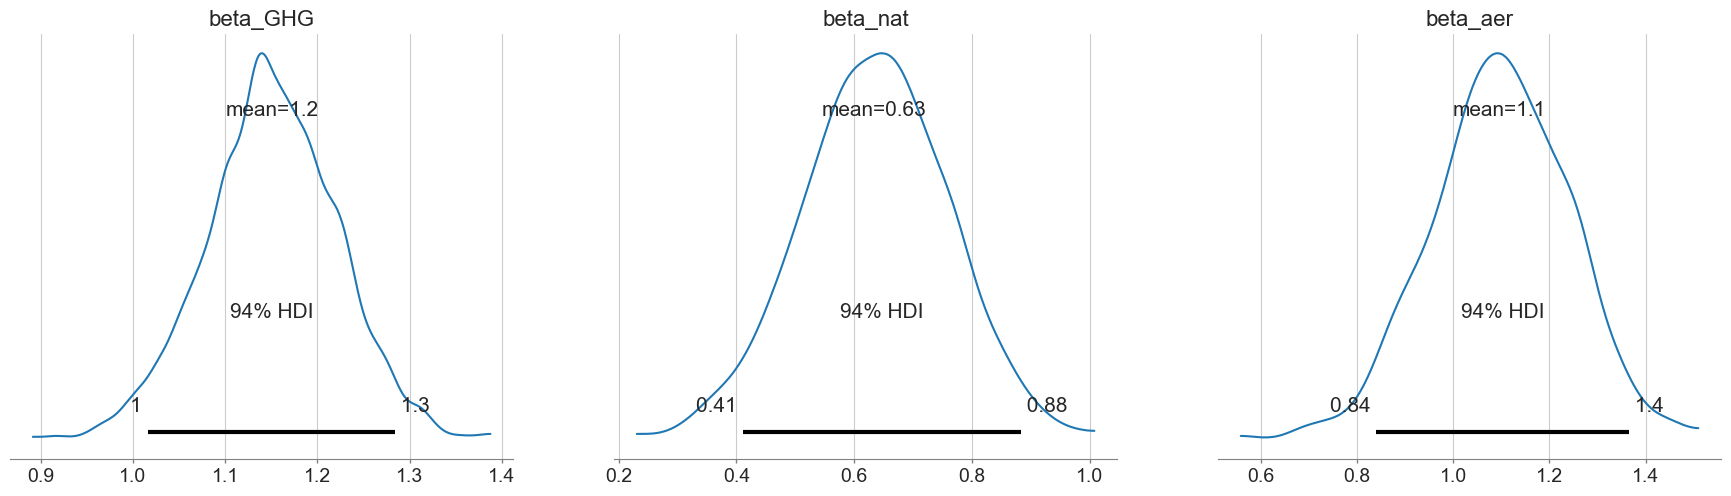

In [207]:
az.plot_posterior(trace,var_names=["beta_GHG","beta_nat","beta_aer"])

array([<Axes: title={'center': 'tau_GHG'}>,
       <Axes: title={'center': 'tau_aer'}>,
       <Axes: title={'center': 'tau_nat'}>,
       <Axes: title={'center': 'tau_CO2'}>], dtype=object)

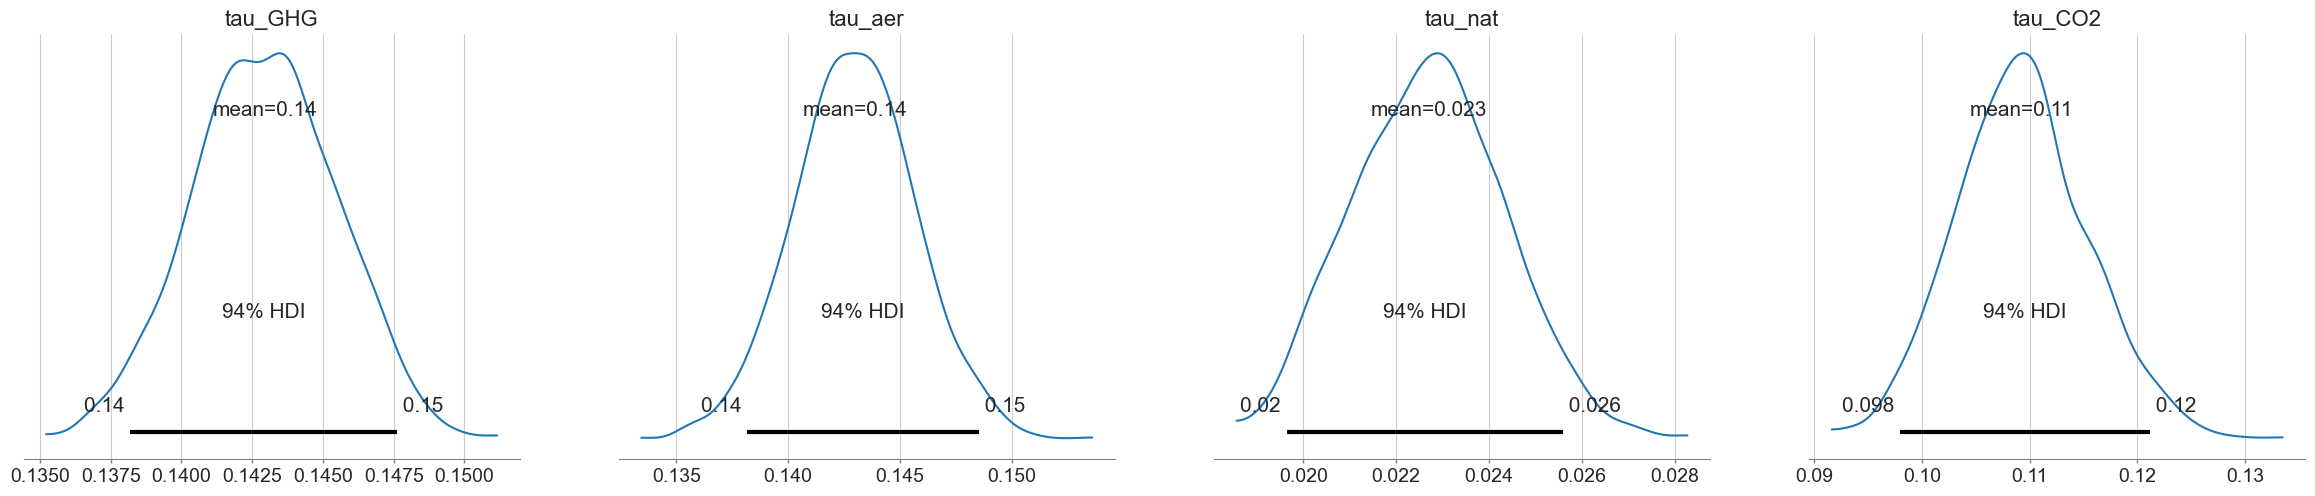

In [212]:
az.plot_posterior(trace,var_names=[f"tau_{fcg}" for fcg in ["GHG","aer","nat","CO2"] ])

Text(0.5, 1.0, 'Attributable warming relative to 1850-1900 baseline (66% HDI)')

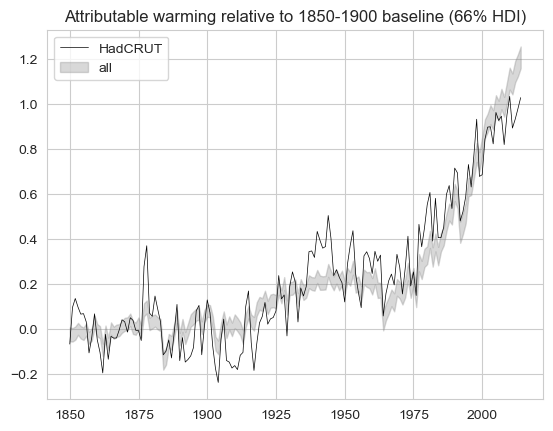

In [209]:
#tmp=[plt.plot(time,np.average(GCM_F["hist-CO2"][m],axis=0),c="g") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.attributable_all,smooth=False,color="g")
#az.plot_hdi(time,trace.posterior.F_historical,smooth=False,color="b")
hdi_prob=.66
time=np.arange(165)+1850
plt.plot(time,H_obs.values,c="k",lw=.5,label="HadCRUT")
az.plot_hdi(time,trace.posterior.H_forced,
            hdi_prob=hdi_prob,
            smooth=False,
            color="gray",
           fill_kwargs={'label': 'all', 'alpha': 0.3})

plt.legend()
plt.title("Attributable warming relative to 1850-1900 baseline (66% HDI)")
#tmp=[plt.plot(time,np.average(GCM_F["hist-GHG"][m],axis=0)-np.average(GCM_F["hist-CO2"][m],axis=0),c="b") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.F_nonCO2,smooth=False,color="b")

A few problems with the simple random-effects model:
* We assume that the inter-model spread in the estimate of forcings is constant in time- this is not really true as the difference between model responses grows with time.
* We could eventually estimate this by model TCR or ECS?  But seems like overkill.
* If the distribution of forced responses/ECS is truly bimodal we might want to estimate this using a Gaussian mixture model.

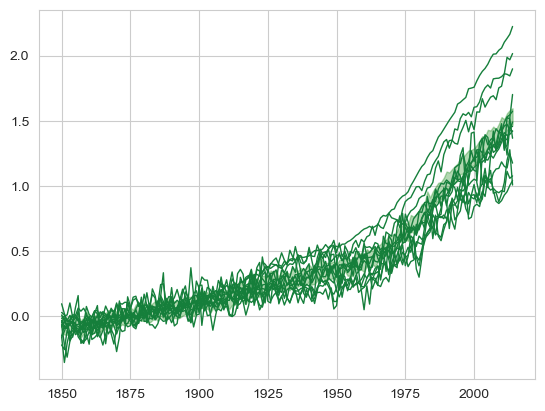

In [218]:
hdi_prob=.95
az.plot_hdi(time,trace.posterior.F_GHG,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'n', 'alpha': 0.3})
for m in GCM_F["hist-GHG"].keys():
    co2_ens=GCM_F["hist-GHG"][m]
    plt.plot(time,np.average(co2_ens,axis=0),lw=1,c=cm.Greens(.8))

# Correlated posteriors
The high correlation between the posteriors for $\beta_{GHG}$ and $\beta_{aer}$ reflects the epistemic uncertainty in how to assign the predictive power between two highly collinear forcings: as GHGs increase the temperature, aerosols decrease it.  So there are many combinations of $\beta_{GHG}$ and $\beta_{aer}$ that fit the data equally well.

The correlations of both with $\beta_{nat}$ are small- it's clear when and how much we can attribute observed global mean T variations to anthropogenic vs natural forcings.


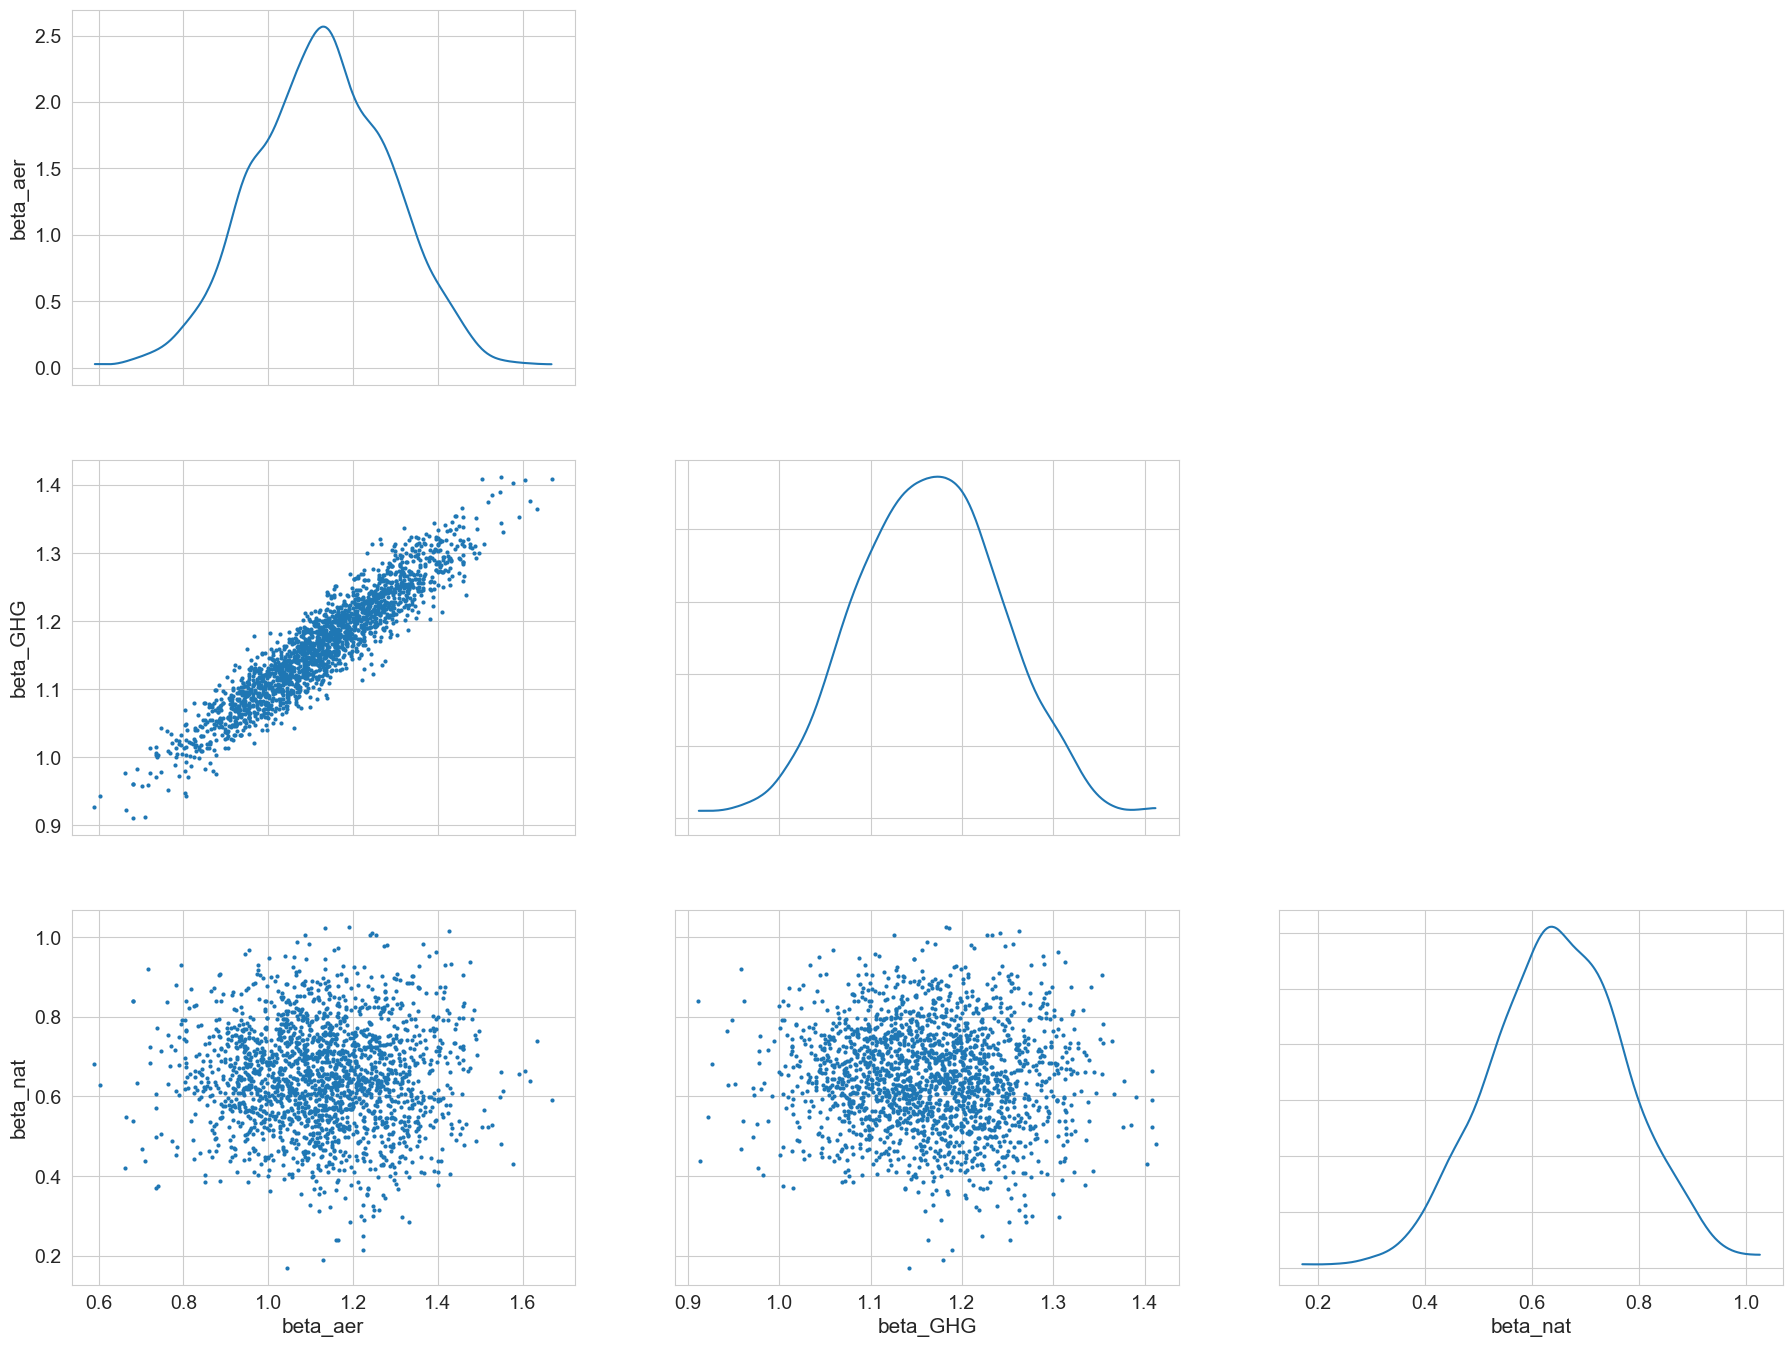

In [79]:
axes=az.plot_pair(trace,var_names=["beta_aer","beta_GHG","beta_nat"],marginals=True)
# axes[1,0].set_ylabel("β_GHG")
# axes[1,0].set_ylabel("β_aer")

In [ ]:
ForcingColors={}
ForcingColors["CO2"]="green"
ForcingColors["nonCO2"]="purple"
ForcingColors["aer"]="orange"
ForcingColors["nat"]="red"

## Attributable warming
How much year-to-year warming is attributable to CO2 only?

Text(0.5, 1.0, 'Attributable warming relative to 1850-1900 baseline (66% HDI)')

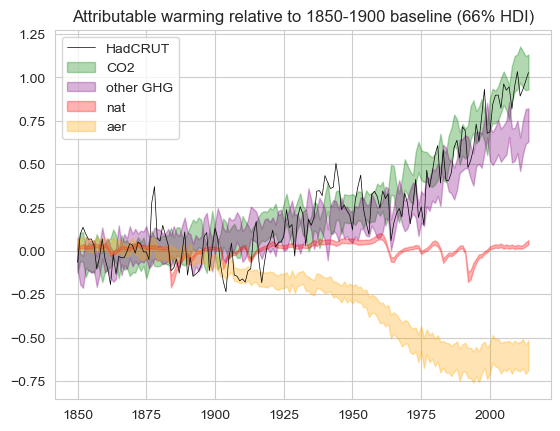

In [219]:
#tmp=[plt.plot(time,np.average(GCM_F["hist-CO2"][m],axis=0),c="g") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.attributable_all,smooth=False,color="g")
#az.plot_hdi(time,trace.posterior.F_historical,smooth=False,color="b")
hdi_prob=.66
time=np.arange(165)+1850
plt.plot(time,H_obs.values,c="k",lw=.5,label="HadCRUT")
az.plot_hdi(time,trace.posterior.attributable_CO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="green",
           fill_kwargs={'label': 'CO2', 'alpha': 0.3})
az.plot_hdi(time,trace.posterior.attributable_nonCO2,
            hdi_prob=hdi_prob,
            smooth=False,
            color="purple",
           fill_kwargs={'label': 'other GHG', 'alpha': 0.3})

az.plot_hdi(time,trace.posterior.attributable_nat,
            hdi_prob=hdi_prob,
            smooth=False,
            color="red",
           fill_kwargs={'label': 'nat', 'alpha': 0.3})

az.plot_hdi(time,trace.posterior.attributable_aer,
            hdi_prob=hdi_prob,
            smooth=False,
            color="orange",
           fill_kwargs={'label': 'aer', 'alpha': 0.3})
plt.legend()
plt.title("Attributable warming relative to 1850-1900 baseline (66% HDI)")
#tmp=[plt.plot(time,np.average(GCM_F["hist-GHG"][m],axis=0)-np.average(GCM_F["hist-CO2"][m],axis=0),c="b") for m in models[has_co2]]
#az.plot_hdi(time,trace.posterior.F_nonCO2,smooth=False,color="b")

Another way to visualize this: stack the posterior mean contributions from each forcing.  This way we can see that CO2 and non-CO2 GHGs warm, but the contribution of non-CO2 GHGs is largely offset by aerosols.

In [87]:
def barplot(trace,all_experiments=["CO2","nat","aer","nonCO2"]):
    T=trace.posterior.F_aer.time+1850

    posbottom=np.zeros_like(T)
    negbottom=np.zeros_like(T)
    
    for experiment in all_experiments:
        just_exp=getattr(trace.posterior,"attributable_"+experiment).mean(dim=["chain","draw"]).to_numpy()
        plt.bar(T,just_exp,bottom=np.where(just_exp>0,posbottom,negbottom),color=ForcingColors[experiment],\
                label=experiment)

        posbottom=np.where(just_exp>0,posbottom+just_exp,posbottom)
        negbottom=np.where(just_exp<0,negbottom+just_exp,negbottom)
    

    plt.plot(T,H_obs.values,c="k",lw=.5,label="HadCRUT")
    
    plt.legend(ncol=2)

Text(0.5, 1.0, 'Stacked annual contribution of each forcing to ΔT (posterior mean)')

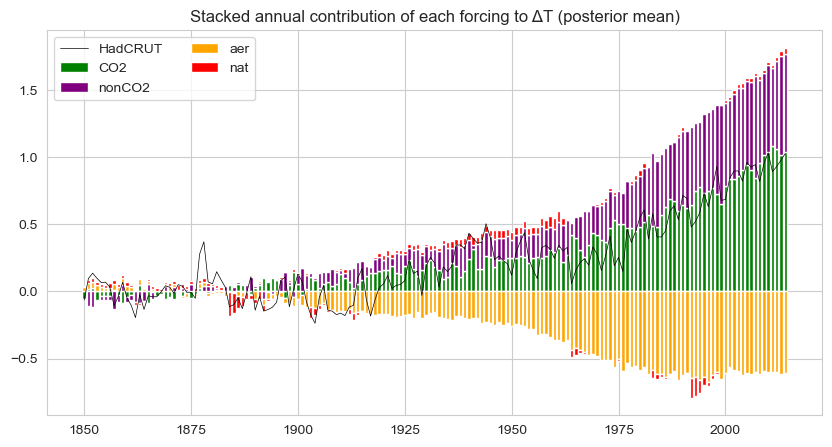

In [220]:
plt.figure(figsize=(10,5))
barplot(trace,all_experiments=["CO2","nonCO2","aer","nat"])
plt.title("Stacked annual contribution of each forcing to ΔT (posterior mean)")

# LAST WORKING VERSION 
DO NOT MESS WITH THIS


In [ ]:
def create_multi_forcing_model(GCM_F, forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'], 
                                n_years=165, H_obs=None, estimate_betas=True,use_historical=False,
                               rho_mean=[.6,-.25,.2],rho_std=[.1,.1,.1],
                               sigma_innov_mean=[.1,.1,.1],sigma_innov_std=[.01,.01,.01]):
    """
    Create joint hierarchical model for multiple DAMIP forcings with detection & attribution.
    
    Parameters:
    -----------
    GCM_F : dict
        GCM_F[forcing][model] = array of shape (n_ensemble, n_years)
        GCM_F["piControl"][model] = array of shape (n_control, n_years) for internal variability
    forcings : list of str
        List of forcing types to model jointly
    n_years : int
        Number of years (default 165)
    H_obs : array-like, shape (n_years,), optional
        Observed time series to attribute
    estimate_betas : bool
        Whether to estimate scaling factors for detection & attribution
    
    Returns:
    --------
    pm.Model object, dict of submodels
    """
    # Get all unique model names across forcings
    all_models = set()
    for forcing in forcings:
        if forcing in GCM_F:
            all_models.update(GCM_F[forcing].keys())
    model_names = sorted(list(all_models))
    n_models = len(model_names)
    
    # Map forcing names to clean variable names
    forcing_map = {
        'hist-aer': 'aer',
        'hist-CO2': 'CO2',
        'hist-nat': 'nat',
        'hist-GHG': 'GHG',
        'historical': 'all'
    }
    
    # Setup coordinates
    coords = {
        "time": np.arange(n_years),
        "model": model_names,
    }
    
    # Add ensemble coordinates AND model-specific coordinates for each forcing
    for forcing in forcings + ["historical"]:
        if forcing not in GCM_F:
            continue
        forcing_clean = forcing_map[forcing]
        
        # Add model coordinate for this forcing (list of models with this forcing)
        forcing_models = list(GCM_F[forcing].keys())
        coords[f"model_{forcing_clean}"] = forcing_models
        
        # Add ensemble coordinates for each model
        for model_name in forcing_models:
            n_ensemble = GCM_F[forcing][model_name].shape[0]
            coords[f"ensemble_{forcing_clean}_{model_name}"] = np.arange(n_ensemble)
    
#     # Add piControl coordinates if available
#     if "piControl" in GCM_F:
#         for model_name in GCM_F["piControl"].keys():
#             n_control = GCM_F["piControl"][model_name].shape[0]
#             coords[f"ensemble_piControl_{model_name}"] = np.arange(n_control)
    
    with pm.Model(coords=coords) as model:
        # ===== Shared within-model variability =====
        # Same sigma for all forcings (internal variability)
        sigma_internal = pm.HalfNormal("sigma_internal", sigma=1.0)
        
        # ===== Store submodels and forcing-specific parameters =====
        submodels = {}
        F_dict = {}  # Store the latent true forced responses
        
        # ===== Process each forcing =====
        for forcing in forcings:
            if forcing not in GCM_F:
                print(f"Warning: {forcing} not found in GCM_F, skipping...")
                continue
                
            forcing_clean = forcing_map[forcing]
            forcing_data = GCM_F[forcing]
            forcing_models = list(forcing_data.keys())
            n_forcing_models = len(forcing_models)
            
            # Between-model variability (structural uncertainty) - specific to each forcing
            tau = pm.HalfNormal(f"tau_{forcing_clean}", sigma=0.5)
            
            # Latent "true" forced response for this forcing
            F_mean = pm.Normal(f"F_{forcing_clean}", mu=0, sigma=2, dims="time")
            
            # Model-specific latent forced responses
            # F_model^true ~ N(F, tau) for each model
            # Only create for models that have data for this forcing
            F_models = pm.Normal(
                f"F_{forcing_clean}_model_true",
                mu=F_mean,
                sigma=tau,
                shape=(n_forcing_models, n_years),
                dims=(f"model_{forcing_clean}", "time")
            )
            
            # Store the latent forcing for derived quantities
            F_dict[forcing_clean] = F_mean
            
            # Create sub-models for each GCM
            submodels[forcing_clean] = {}
            for i, model_name in enumerate(forcing_models):
                ensemble_data = forcing_data[model_name]
                
                submodels[forcing_clean][model_name] = create_forcing_submodel(
                    ensemble_data=ensemble_data,
                    model_name=model_name,
                    forcing_name=forcing_clean,
                    F_true=F_models[i, :],
                    sigma_shared=sigma_internal
                )
            
            # Multi-model mean and spread for this forcing
            mm_mean = pm.Deterministic(
                f"mm_mean_{forcing_clean}", 
                F_models.mean(axis=0), 
                dims="time"
            )
            mm_std = pm.Deterministic(
                f"mm_std_{forcing_clean}", 
                F_models.std(axis=0), 
                dims="time"
            )
        
        # ===== Derived forcing: F_nonCO2 = F_GHG - F_CO2 =====
        if 'GHG' in F_dict and 'CO2' in F_dict:
            F_nonCO2 = pm.Deterministic(
                "F_nonCO2",
                F_dict['GHG'] - F_dict['CO2'],
                dims="time"
            )
            F_dict['nonCO2'] = F_nonCO2
        
        # ===== Optional: Total anthropogenic forcing =====
        if 'GHG' in F_dict and 'aer' in F_dict:
            F_anthro = pm.Deterministic(
                "F_anthro",
                F_dict['GHG'] + F_dict['aer'],  # GHG + aerosols
                dims="time"
            )
        
        # ===== Detection & Attribution Component =====
        if H_obs is not None and estimate_betas:
            
            # ===== Scaling factors (betas) =====
            # beta_GHG applies to both CO2 and nonCO2
#             beta_GHG = pm.Normal("beta_GHG", mu=1, sigma=0.5)
#             beta_aer = pm.Normal("beta_aer", mu=1, sigma=0.5)
#             beta_nat = pm.Normal("beta_nat", mu=1, sigma=0.5)
            
            beta_GHG = pm.HalfNormal("beta_GHG",sigma=0.5)
            beta_aer = pm.HalfNormal("beta_aer",  sigma=0.5)
            beta_nat = pm.HalfNormal("beta_nat", sigma=0.5)
            
     
            # ===== Construct expected observations =====
            # H = beta_aer*F_aer + beta_GHG*F_CO2 + beta_GHG*F_nonCO2 + beta_nat*F_nat
           
            H_forced = pm.math.zeros_like(time)
            
            
            if 'aer' in F_dict:
                H_forced = H_forced + beta_aer * F_dict['aer']
            if 'CO2' in F_dict:
                H_forced = H_forced + beta_GHG * F_dict['CO2']
            if 'nonCO2' in F_dict:
                H_forced = H_forced + beta_GHG * F_dict['nonCO2']
            if 'nat' in F_dict:
                H_forced = H_forced + beta_nat * F_dict['nat']
            
            H_forced = pm.Deterministic("H_forced", H_forced, dims="time")
            
            
            
            internal_variability=H_obs.values-H_forced
            
            
            # ===== Sample the AR(p) parameters learned from piControl =====
            
            rho=pm.Normal("rho",mu=rho_mean,sigma=rho_std)

            sigma_innovation=pm.TruncatedNormal("sigma_innovation",
                                       mu=sigma_innov_mean,
                                                sigma=sigma_innov_std,
                                               lower=0)
            
            pm.Potential("arp_likelihood", logp_arp(internal_variability, rho=rho, sigma=sigma_innovation))
            
            # ===== Process each forcing =====
            if use_historical:
                forcing = "historical"  
                forcing_clean = "all"
                forcing_data = GCM_F["historical"]
                forcing_models = list(forcing_data.keys())

                n_forcing_models = len(forcing_models)

                forcing_models = list(GCM_F[forcing].keys())


                # Between-model variability (structural uncertainty) - specific to each forcing
                tau = pm.HalfNormal(f"tau_{forcing_clean}", sigma=0.5)

                # Latent "true" forced response for this forcing
                F_mean = pm.Deterministic("F_historical",\
                                          F_dict["aer"]+F_dict["CO2"]+F_dict["nonCO2"]+F_dict["nat"])

                # Model-specific latent forced responses
                # F_model^true ~ N(F, tau) for each model
                # Only create for models that have data for this forcing
                F_models = pm.Normal(
                    f"F_{forcing_clean}_model_true",
                    mu=F_mean,
                    sigma=tau,
                    shape=(n_forcing_models, n_years),
                    dims=(f"model_{forcing_clean}", "time")
                )

                # Store the latent forcing for derived quantities
                F_dict[forcing_clean] = F_mean

                # Create sub-models for each GCM
                submodels[forcing_clean] = {}
                for i, model_name in enumerate(forcing_models):
                    ensemble_data = forcing_data[model_name]

                    submodels[forcing_clean][model_name] = create_forcing_submodel(
                        ensemble_data=ensemble_data,
                        model_name=model_name,
                        forcing_name=forcing_clean,
                        F_true=F_models[i, :],
                        sigma_shared=sigma_internal
                    )




            
            # ===== Attributable responses =====
            # attributable_forcing = beta_forcing * F_forcing
            if 'aer' in F_dict:
                pm.Deterministic("attributable_aer", beta_aer * F_dict['aer'], dims="time")
            if 'CO2' in F_dict:
                pm.Deterministic("attributable_CO2", beta_GHG * F_dict['CO2'], dims="time")
            if 'nonCO2' in F_dict:
                pm.Deterministic("attributable_nonCO2", beta_GHG * F_dict['nonCO2'], dims="time")
            if 'nat' in F_dict:
                pm.Deterministic("attributable_nat", beta_nat * F_dict['nat'], dims="time")
           
            
            # Total attributable anthropogenic
            if 'GHG' in F_dict and 'aer' in F_dict:
                pm.Deterministic(
                    "attributable_anthro",
                    beta_GHG * F_dict['GHG'] + beta_aer * F_dict['aer'],
                    dims="time"
                )
    
    return model, submodels


def fit_multi_forcing_model(GCM_F, forcings=['hist-aer', 'hist-CO2', 'hist-nat', 'hist-GHG'],
                             n_years=165, H_obs=None, estimate_betas=True,
                             n_samples=2000, n_tune=1000, n_chains=4,\
                           use_historical=False):
    """
    Fit the multi-forcing hierarchical model.
    
    Parameters:
    -----------
    GCM_F : dict
        GCM_F[forcing][model] = array of shape (n_ensemble, n_years)
    forcings : list of str
        List of forcing types to model jointly
    H_obs : array-like, shape (n_years,), optional
        Observed time series for detection & attribution
    estimate_betas : bool
        Whether to estimate scaling factors
    n_samples, n_tune, n_chains : int
        MCMC sampling parameters
        
    Returns:
    --------
    model, trace, submodels
    """
    # Create model
    model, submodels = create_multi_forcing_model(GCM_F, forcings, n_years, H_obs, estimate_betas,use_historical)
    
    # Sample
    with model:
        trace = pm.sample(
            draws=n_samples,
            tune=n_tune,
            chains=n_chains,
            target_accept=0.95,
            return_inferencedata=True
        )
    
    return model, trace, submodels

# Scratchwork

## Does concatenating piControl runs introduce spurious noise?
No, if we stack the last 170 years (shortest CMIP6 control run length) of each run, the posteriors are fairly identical.

In [ ]:
C_stack=np.stack([GCM_F["piControl"][model][-170:] for model in GCM_F["piControl"].keys()])

n_ar=3

with pm.Model() as ARstack:
    rho=pm.Uniform("rho",-1,1,shape=(n_ar))
    sigma_innov=pm.HalfNormal("sigma_innov",10)
    pm.AR("lik",rho=rho,sigma=sigma_innov,observed=C_stack)
    ARstack_trace=pm.sample()
az.plot_posterior(ARstack_trace)

## Can we use a gaussian process to more accurately characterize the noise?
Not really, and anyway the sampling from a GP-parameterized covariance matrix takes too long

In [ ]:
fit_a_GP=False
if fit_a_GP:
    # GAUSSIAN PROCESS
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel

    # --- Define kernels for each timescale ---

    # Short-term: year-to-year (1–2 years)
    kernel_short = 1.0 * RBF(length_scale=1.0)

    # Medium-term: decadal (~10 years)
    kernel_medium = 1.0 * RBF(length_scale=10.0)

    # Long-term: halfcentennial (~50 years)
    kernel_long = 1.0 * RBF(length_scale=50.0)

    # Noise kernel
    noise_kernel = WhiteKernel(noise_level=0.1)

    # Combine all kernels
    kernel = kernel_short + kernel_medium + kernel_long + noise_kernel

    # --- Build and fit GP model ---
    gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)

    gp.fit(t_c.reshape(-1, 1), C_conc.reshape(-1, 1))
    # Parse out parameters (will have to do by hand)
    opt_kernel = gp.kernel_